In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 207 µs (started: 2023-10-06 13:33:56 +00:00)


# Algorithms for solving Linear Programming Problems

We will now present a brief overview of algorithms for solving LPs. LPs can be solved quite efficiently and there are many algorithms for doing so. Here is a brief historical presentation of the algorithms:
  - Linear programming problems were conceived of in their modern form in 1939 by Russian mathematician Leonid Kantorovich and independently during world war II by American mathematician George Danzig. 
  - George Danzig came up with the famous Simplex algorithm for solving LPs during world war II while working for the RAND corporation. He published his work in 1947 at the end of the war. 
  - The Simplex algorithm is a very powerful and elegant greedy approach to solving LPs. We will describe it in more detail below. It runs very fast in practice but is known to be exponential time in the worst-case. However, it must be noted that the worst-case instances for Simplex are theoretical in nature. For most problems we encounter Simplex performs quite well and has a polynomial "average case" complexity.
  - The first algorithm that can solve LPs in polynomial time was discovered by Leonid Kachiyan in the late 70s and is called the Ellipsoidal algorithm. It is a very interesting idea but rarely used in practive to solve LPs.
  - In the 1980s, Narendra Karamarkar (then working at IBM) and later Yurii Nestorov and Arkady Nemirovsky showed that interior point methods can solve LPs in polynomial time and are fast in practice. 
  - Despite its suboptimal worst-case the Simplex algorithm still remains a widely used algorithm for solving LPs and has some theoretical advantages over interior point methods.
  
 The key takeaways are that LPs can be solved quite fast in practice and the best known algorithms take time that is polynomial in the problem size. In practice, problems involving millions of decision variables and constraints can be routinely solved. If the problems have special structure in terms of how the variables appear in various constraints, we can exploit them to solve them even faster. 
 
 Let us dive a little deeper into the Simplex method. It is a rewarding exercise since it also teaches us about the properties of convex polytopes.

## The Simplex Algorithm

At a high level, the simplex algorithm is a greedy algorithm that is based on the properties of polyhedra: a geometric object that is closely related to linear programs. Let us first understand polyhedra briefly and then provide a description of how Simplex works.

Consider a LP of the form 

$$\begin{array}{rcllll}
\max & c_1 x_1 + \cdots + c_n x_n &  & \text{Obj. Fun.} \\
\mathsf{s.t.} & A_{11} x_1 + \cdots + A_{1n} x_n & \leq b_1 & \text{Constr. 1 } \\ 
& \ddots & \vdots \\ 
& A_{m1}x_1 + \cdots + A_{mn}x_n & \leq b_m & \text{Constr. m } \\ 
\end{array}$$

There are $n$ decision variables $x_1, \ldots, x_n$ and $m$ constraints shown above. A point $(x_1, \ldots, x_n)$ in 
$n-$ dimensional space is feasible for the LP if it satisfies each and every one of the $m$ constraints.  The set of all feasible points forms the feasible region. 

### Important Note

We will focus our presentation for the case when the LP has an optimal solution. Note that it is relatively easy to handle the case when the LP is infeasible or unbounded but that introduces more caveats and is the subject of a dedicated course on this topic rather than a brief presentation.

#### Example - 1
As an example, consider the following LP:

$$ \begin{array}{rcccll}
\max & x &+ y& - z \\ 
& x & & & \leq 1 \\ 
& -x && & \leq 1 \\ 
& & y&  & \leq 1 \\ 
& & -y& & \leq 1 \\ 
& && z & \leq 1 \\ 
& && -z & \leq 1 \\ 
\end{array}$$

A point $(x, y, z)$ is feasible if it satisfies the constraints. The constraints for this LP are particularly simple: they specify that $x$ must be between $[-1, 1]$ and similarly for $y, z$.  Therefore, the feasible region is a cube with $8$ corners as shown below:

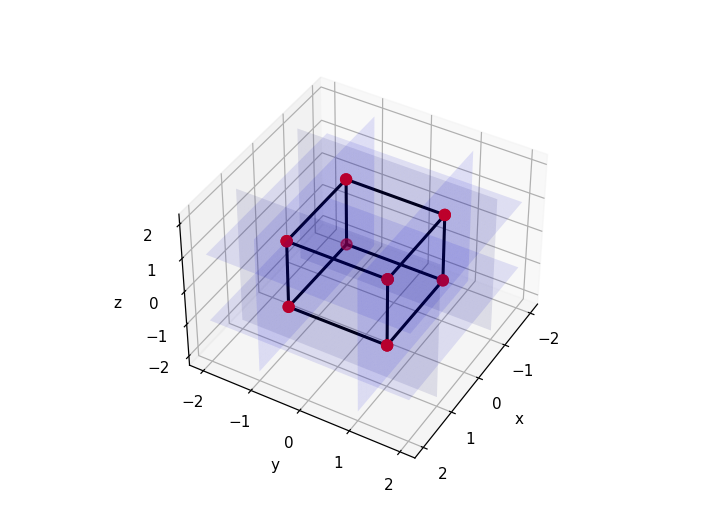

Notice that each face of the cube corresponds to one of the constraints. For instance the top face represents the constraint $z \leq 1$ and points on that face satisfy $z = 1$.  Similarly the "left" face represents the constraint $ -y \leq 1$ (or $y \geq -1$) and all the points on the face satisfy $y = -1$. 



Thus, the constraints of a LP define faces and the region bounded by all the faces forms a (convex) polyhedron.  A cube is an example of such a polyhedron. In two dimensions (if the problem had just two decision variables instead of three), a polyhedron is called a polygon.

~~~
The feasible region of an LP is called a polyhedron: a region in space bounded by a set of faces which are hyperplanes.  These faces arise from each of the constraints in the LP. 
~~~




In [15]:
import plotly.graph_objects as go
import numpy as np

# Define the vertices of the cube
vertices = np.array([
    [-1, -1, -1],
    [1, -1, -1],
    [1, 1, -1],
    [-1, 1, -1],
    [-1, -1, 1],
    [1, -1, 1],
    [1, 1, 1],
    [-1, 1, 1]
])

# Define the edges connecting vertices
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0], # bottom edges
    [4, 5], [5, 6], [6, 7], [7, 4], # top edges
    [0, 4], [1, 5], [2, 6], [3, 7]  # side edges
]

# Create the figure
fig = go.Figure()

# Add edges
for edge in edges:
    fig.add_trace(go.Scatter3d(
        x=vertices[edge, 0],
        y=vertices[edge, 1],
        z=vertices[edge, 2],
        mode='lines',
        line=dict(color='darkblue', width=5)
    ))

# Add vertices
fig.add_trace(go.Scatter3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    mode='markers',
    marker=dict(color='red', size=5)
))

# Add origin
fig.add_trace(go.Scatter3d(
    x=[0],y=[0],z=[0], mode='markers',
    marker=dict(color='green', size=8)
))

# Set the layout
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-2, 2], showgrid=False),
        yaxis=dict(range=[-2, 2], showgrid=False),
        zaxis=dict(range=[-2, 2], showgrid=False),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the figure
fig.show()

### Geometry: Polyhedra, Faces and Vertices

A polyhedron over variables $x_1, \ldots, x_n$ is a region of space that satisfies a given set of $m$ constraints of the form : 

$$\begin{array}{rcllll}
 & A_{11} x_1 + \cdots + A_{1n} x_n & \leq b_1 & \text{Face }\ F_1 \\ 
& \ddots & \vdots \\ 
& A_{m1}x_1 + \cdots + A_{mn}x_n & \leq b_m & \text{Face }\ F_m \\ 
\end{array}$$

Each constraint (called a face) is a simple linear inequality that specifies points that are on a hyper-plane or to one side of it. In mathematics, each such constraint is called a "half-space" because it cuts the space of all points in $\mathbb{R}^n$ into two parts.  A polyhedron is thus the intersection of $m \geq 0$ half spaces. 

A point in the polyhedron $(x_1, \ldots, x_n)$ is said to lie on a face $F_i$ if it satisfies:
$$ A_{i1} x_1 + A_{i2} x_2 + \cdots + A_{in} x_n = b_i $$ 
In other words, the point satisfies the inequailty for the face $F_i$ with an equality.  A point $(x_1, \ldots, x_n)$ in the polyhedron that satisfies $ A_{i1} x_1 + A_{i2} x_2 + \cdots + A_{in} x_n < b_i $ will therefore __not__ lie on the face $F_i$.

#### Example 

Going back to the example of the cube, notice that the point $(1,1/2, -1/4)$ lies in the face $ x \leq 1$ since it satisfies $x = 1$. However, it does not lie on the face $y \geq -1$ or $z \leq 1$ or any other face.
Similarly, the point $(-1, -1, 1)$ lies on three faces simultaneously: $x \geq -1$, $y \geq -1$ and $z \leq 1$ since it satisfies the three inequalities with an equality. 

### Vertex 

A key concept in the geometry of polyhedra is called a vertex (or a corner) of the polyhedron. Suppose a point $(x_1, \ldots, x_n)$ satisfies all the constraints in the polyhedron and additionally lies on $n$ distinct faces, it is called a __vertex__ of the polyhedron. Note the two important criteria:
  - The point must be part of the polyhedron : it satisfies all the constraints.
  - It must lie on $n$ different faces of the polyhedron where $n$ is the number of decision variables or the dimensionality.
  
#### Example: Vertices of the Cube

Returning back to the example of a cube in three dimensions: 

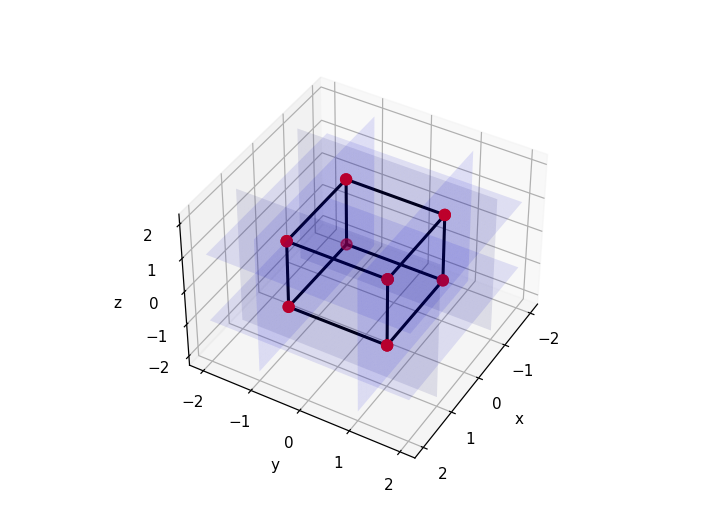

$$ \begin{array}{rccclll}
& x & & & \leq 1 & F_1 \\ 
& -x && & \leq 1 & F_2 \\ 
& & y&  & \leq 1 & F_3\\ 
& & -y& & \leq 1 & F_4\\ 
& && z & \leq 1 & F_5\\ 
& && -z & \leq 1 & F_6 \\ 
\end{array}$$
Notice that there are $8$ vertices and corresponding to each vertex we show the faces it lies on.

$$\begin{array}{||l|l||}
\hline
\text{Vertex} & \text{Faces } \\ 
\hline 
(-1, -1, -1) & F_2, F_4, F_6 \\
(-1, -1, 1) & F_2, F_4, F_5 \\ 
(-1, 1, -1) & F_2, F_3, F_6 \\ 
(-1, 1, 1 ) & F_2, F_4, F_5 \\ 
(1, -1, -1) & F_1, F_4, F_6 \\ 
(1, -1, 1) & F_1, F_4, F_5 \\ 
(1, 1, -1) & F_1, F_3, F_6 \\ 
(1, 1, 1) & F_1, F_3, F_5 \\ 
\hline
\end{array}$$

Note that the cube has $3$ variables $(x, y, z)$ and therefore a vertex of the cube must lie on three distinct faces of the cube.  






### Example 2: Modified Cube

Consider the following polyhedron with 5 faces:

$$\begin{array}{lllll}
x & & &\leq 1 & F_1 \\ 
-x & & & \leq 1 & F_2 \\ 
& y & & \leq 1 & F_3 \\ 
 & 0.1 y & - z & \leq 1 & F_4 \\ 
-x & -y & -z & \leq 2.5 & F_5 \\ 
\end{array}$$

Here is a diagram the polyhedron showing the faces and the vertices:
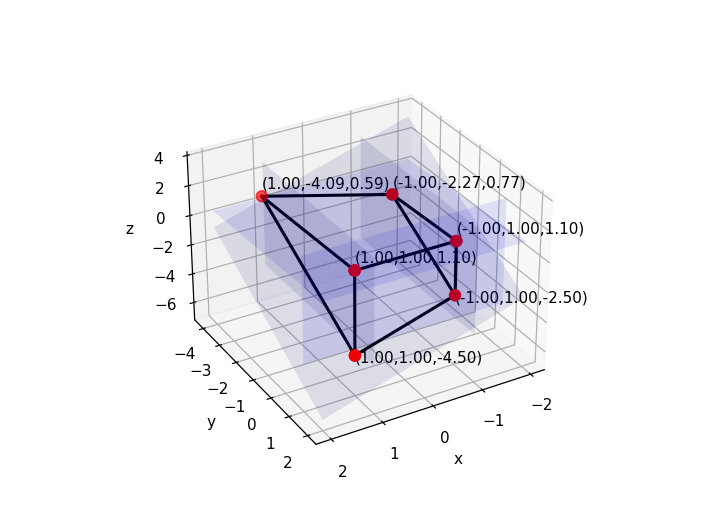

Notice that there are 6 vertices and each vertex lies on three faces while satisfying the remaining constraints as well. 

$$\begin{array}{|l|l|}
\hline
\text{Vertex} & \text{Faces} \\
\hline
(1, -4.09,0.59) & F_1, F_4, F_5 \\ 
(-1, -2.27, 0.77) & F_2, F_4, F_5 \\ 
(1, 1, -4.5) & F_1 , F_3, F_5 \\ 
(-1, 1, -2.5) & F_2, F_3, F_5 \\ 
(1, 1, 1.1) & F_1, F_3, F_4 \\ 
(-1, 1, 1.1) & F_1, F_3, F_4 \\ 
\hline
\end{array}$$




### Adjacent Vertices

Notice from the drawing of polyhedra that there is a notion of two vertices being adjacent to each other. 
In the previous example, notice that the vertex $(1,1, -4.5)$ is adjacent to $(1, 1, 1.1)$ whereas 
the vertex $(-1, 1, -2.5)$ is not adjacent to $(1, -4.09, 0.59)$.

Two vertices $v_i$ and $v_j$ of a polyhedron are adjacent to each other if they both lie on 
$n-1$ faces in common. Notice that vertices $v_i, v_j$ themselves each lie on $n$ faces. If they are adjacent, we 
say that they have $n-1$ of these faces in common.

#### Example

Returning to our previous example: we claimed the vertex $v_1: (1,1, -4.5)$ is adjacent to $v_2: (1, 1, 1.1)$.

Vertex $v_1$ lies on faces $F_1, F_3, F_5$ whereas $v_2$ lies on faces $F_1, F_3, F_4$. Therefore, they have $n-1=2$ faces in common. 

On the other hand vertices $v_1: (1, 1, -4.5) $ and $v_3: (-1, -2.27, 0.77)$ are __not__ adjacent since 
$v_3$ lies on $F_2, F_4, F_5$ which has just one face in common with $v_1$. 

Informally, notice that adjacent vertices is that two adjacent vertices lie on one of the "edges" of the polyhedron though this is not strictly true and there are some special cases where it will not hold.



### Number of vertices

We will briefly address the issue of how many vertices a polyhedron can have. Suppose we have a polyhedron $P$ over $n$ variables and $m$ constraints/faces. We will assume $m \geq n$ since otherwise the polyhedron can be unbounded and we exclude those from our discussion here. 

Consider the example of a hyper-cube in $n$-dimensions. It is given by constraints of the form 

$$x_1 \leq 1,\ x_1 \geq -1,\ x_2 \leq 1,\ x_2 \geq -1, \ldots, x_n \leq 1,\ x_n \geq -1 \,.$$

There are $2n$ constraints/faces in all. However, a $n$ dimensional hypercube has $2^n$ vertices!
Why is that? Each vertex is of the form $(\pm 1, \pm 1, \ldots, \pm 1)$. Depending on whether you choose
$+1/-1$ for each individual dimension, there are $2^n$ corners/vertices. 

$$\begin{array}{l l l }
n & \# \text{faces} & \# \text{vertices} \\ 
\hline
3 & 6 & 8 \\ 
4 & 8 & 16 \\ 
5 & 10 & 32 \\ 
6 & 12 & 64 \\ 
7 & 14 & 128 \\ 
&\vdots && \\ 
100 & 200 & 2^{100} \\
\hline
\end{array}$$

A hyper-cube over 100 dimensions has $2^{100} \approx 10^{34}$ vertices. In contrast, the number of molecules in 
one liter volume of air at room temperature and pressure is rougly $3 \times 10^{22}$ (work it out from 
 Avagadro's number and 1 mole of air at room temperature is rougly 25 liters). Thus, it is practically 
 impossible for us  to systematically find and enumerate all the vertices of polyhedra beyond, say,  five dimensions and twenty constraints. 


## Simplex algorithm at a high level

At a high level the simplex algorithm is based on the following important fact:

~~~
If a Linear Programming problem has an optimal solution then the optimal solution can be found at one of the corners of the polyhedron for the feasible region.
~~~

Recall once again that we are excluding infeasible and unbounded LPs from this discussion to keep things simpler.

At a high level the simplex algorithm starts from an initial vertex $v = v_0$ of the polyhedron and at each vertex $v$ it greedily moves to an adjacent vertex that has a higher value of the objective function until it can do so no more. 

  1. Initialize by finding a vertex $v = v_0$ of the polyhedron.
     - Finding an initial vertex is done by solving an auxilliary problem.
     - If the auxilliary problem fails to find an initial vertex we declare the problem infeasible (details are elided).
  2. Repeat the following steps until termination.
     - Find a vertex $v'$ that is adjacent to the current vertex $v$ and increases the value of the objective function.
       * If all adjacent vertices do not improve the value of the objective function then TERMINATE with current vertex $v$ as the optimal solution.
     - Set  $v$ to the vertex $v'$.

While the description of the algorithm is simple at a high level there are some important issues that need to be addressed so that the algorithm is efficient in practice:
  - Simplex avoids computing all the vertices of the polyhedron. 
    - The simplex algorithm simply stores one vertex at any point of time and is able to explore all its adjacent ones (calculating them on demand).
 

## Visualizing Polyhedra 

Let us visualize polyhedra using python's numpy and matplotlib packages. We will assume that we have the faces of the polyhedron and the vertices given to us. In practice, a tool like CDD (Cf. https://people.inf.ethz.ch/fukudak/cdd_home/) or Parma Polyhedron Library (PPL) https://www.bugseng.com/content/parma-polyhedra-library can compute vertices given the constraints or vice-versa. The algorithms that these tools use are beyond the scope of this course but we will cover them in a course dedicated to the theory of optimization problems.
For now, we have run these tools ourselves and computed vertices for some three dimensional polyhedra so that we can plot them. 



<div class="alert-block alert-warning">
<p> This content is just for completeness and provided here because (a) Sriram happens to think it is cool; (b) it happens to be very relevant to his research area; (c) he wanted to play with visualizations in matplotlib library and (d) there was much more important work that he was avoiding doing since he had not had any fun in weeks ;-)
<p>  
You may want to skip this if the idea of polyhedra does not appeal to you (no judgements!!).
</div>



In [5]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# This is a useful helper function for plotting 3D surfaces
# in the matplotlib library.
# Inputs are the coefficients of the plane : ax + by + cz + d = 0
# A handle to the axes: plt3d
# bounds on the x,y, z axes: xyz_bnds
def plot3DPlane(a, b, c, d, plt3d, xyz_bnds, col='b'):
    assert abs(a) > 1E-05 or abs(b) > 1E-05 or abs(c) > 1E-05, "All coefficients of hyperplane are too small to plot."
    [xLo, xHi] = xyz_bnds[0] # unpack xyz_bnds
    [yLo, yHi] = xyz_bnds[1]
    [zLo, zHi] = xyz_bnds[2] # done: unpack xyz_bnds
    if c != 0: # coefficient for z dimension of hyper plane is nonzero
        xg = np.linspace(xLo, xHi, 100) # make a grid of x,y points
        yg = np.linspace(yLo, yHi, 100) # we will use 100 equispaced points between lo, hi limits
        x,y = np.meshgrid(xg, yg) # This is a useful way of making a grid
        z = (-a * x - b * y -d)/c # compute the z value corresponding to x, y --> numpy overloads -, *, / to matrices.
        plt3d.plot_surface(x, y, z, color=col, alpha=0.1) # plot
    elif b != 0: # otherwise if y dimension is not zero
        xg = np.linspace(xLo, xHi, 100)
        zg = np.linspace(zLo, zHi, 100)
        x, z= np.meshgrid(xg, zg)
        y = (-a * x  - d)/b
        plt3d.plot_surface(x,y,z, color=col, alpha=0.1)
    else:
        assert(a != 0)
        yg = np.linspace(yLo, yHi, 100)
        zg = np.linspace(zLo, zHi, 100)
        y, z= np.meshgrid(yg, zg)
        x = -d/a
        plt3d.plot_surface(x,y,z, color=col, alpha=0.1)

def drawEdge(pt1, pt2, ax): # Draw a line between two points in 3D
    x = [pt1[0], pt2[0]] # unpack x coordinates
    y = [pt1[1], pt2[1]] # unpack y coordinates
    z = [pt1[2], pt2[2]] # unpack z coordinates
    ax.scatter(x, y, z, c='red', s=50) # draw red spheres
    ax.plot(x, y, z, color='black',lw=2) # plot a thick black line

# ThreeDPolyhedronData
#  This is the main class for storing polyhedra and plotting them
class ThreeDPolyhedronData:
    # Class constructor.
    # constraints:
    # These are the constraints representing the faces of the polyhedron
    # constraints are represented as a list of lists
    # constraints = [ [1, -2, 1, -3], [0, 0, -1, -3], [0, 0, 1, -3], [0, -1, -1, -2]]
    # repersents the polyhedron x - 2 y + z -3 <= 0, -z - 3 <= 0, z - 3 <=0, -x - y -2 <= 0
    # vertices:
    # These are the vertices of the polyhedron
    # vertices = [[0,0, 0], [0, 1, 2], [2, 1, 3], [1, 2, 3]]
    # represents a polyhedron with four vertices (0,0,0), (0, 1, 2), (2, 1, 3), (1, 2, 3)
    # xyz_bnds:
    # This is a set of upper and lower bounds for x, y, z axis to help with plotting.
    def __init__(self, constraints, vertices, xyz_bnds):
        self.d = 3 # Just assume things are three dimensional
        self.__cons = constraints
        assert(all(len(c) == 4 for c in self.__cons))
        self.__verts = vertices
        assert(all(len(v) == 3 for v in self.__verts))

        if xyz_bnds != None:
            self.__xyz_bnds = xyz_bnds
        else:
            self.__xyz_bnds = [ [ -5, 5], [-5, 5], [-5, 5]]

        self.__obj = None

    # Check if a vertex v [x,y,z] lies on a face f [ax, ay, az, b] representing ax*x + ay*y + az*z +b <= 0
    def vertex_lies_on_face(self, v, f):
        assert(len(v) == self.d)
        assert(len(f) == self.d+1)
        s = f[self.d] + sum([fi*vi for (fi, vi) in zip(f, v)])
        assert s <= 01E-06, f'Vertex {v} does not satisfy constraint {f}: {s}' # vertex should be part of the polyhedron
        return abs(s) <= 1E-06 # note that we are not using 0 here to avoid errors due to floating point calculations

    # Create a matrix of true/false entries to look up if for each vertex vi and face fj, vertex vi lies on face fj
    # Rows of this matrix will correspond to vertices
    # columns will correspond to faces
    def compute_face_vertex_map(self):
        # for a polyhedron with k vertices and m constraints this is a
        # k \times m mapping that maps each vertex to the faces that it lies on
        self.__fv_map = [ [self.vertex_lies_on_face(v, f) for f in self.__cons]  for v in self.__verts]

    # check if two vertices indexed by i, j are adjacent
    def is_adjacent(self, i, j):
        assert self.__fv_map != None
        assert 0 <= i and i < len(self.__fv_map)
        assert 0 <= j and j < len(self.__fv_map)
        num_common = sum( fi and fj for (fi, fj) in zip(self.__fv_map[i], self.__fv_map[j]))
        return num_common == self.d -1 # two vertices are adjacent if they have (d-1) faces in common

    def compute_vertex_adjacencies(self):
        self.compute_face_vertex_map()
        n_verts = len(self.__verts)
        self.__adj_map = {i:[] for i in range(n_verts)} # initialize adjacency map to empty
        for i in range(n_verts-1):
            for j in range(i+1, n_verts):
                if self.is_adjacent(i, j):
                    self.__adj_map[i].append(j)
                    self.__adj_map[j].append(i)

    def plot_polyhedron(self):
        self.compute_vertex_adjacencies()
        # prepare a plot and axes
        n_verts = len(self.__verts)
        n_cons = len(self.__cons)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=30, azim=60)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        # show all the faces
        for c in self.__cons:
            plot3DPlane(c[0], c[1], c[2], c[3], ax, self.__xyz_bnds, 'b')
        # plot all the edges
        for i in range(n_verts): # run through all vertices
            if  i in self.__adj_map:
                lst = self.__adj_map[i] # fetch all vertices adjacent to i
                for j in lst:# run through each adjacent vertex of i
                    if i < j: # since each edge occurs twice in our map i -> j and j -> i, just plot once
                        drawEdge(self.__verts[i], self.__verts[j], ax) # plot the edge
        if self.__obj == None: # write down the name of each vertex next to it
            for [x,y,z] in self.__verts:
                if z >= 0:
                    ax.text(x , y, z + 0.5, f'({x:.2f},{y:.2f},{z:.2f})',zdir=None)
                else:
                    ax.text(x , y, z - 0.5, f'({x:.2f},{y:.2f},{z:.2f})',zdir=None)
        plt.show()

# plt.hold(True)

# plot3DPlane(-2, -1, 3, 4, ax, xyz_bnds,'b')
# plot3DPlane(1, -2, -1,3, ax, xyz_bnds,'g')
# plot3DPlane(2, 1, 0, 4, ax, xyz_bnds,'k')
# plot3DPlane(1, 0, 0, -1, ax, xyz_bnds,'r')
# plt.show()

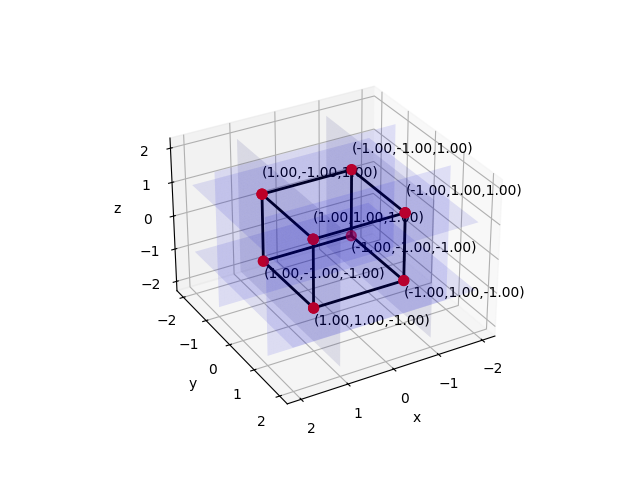

In [6]:
constr = [ [ 1, 0, 0, -1],  # x <= 1
          [-1, 0, 0, -1], # -x <= 1
          [0, 1, 0, -1], # y <= 1
          [0, -1, 0, -1], # -y <= 1
          [0, 0, 1, -1],  # z <= 1
          [0, 0, -1, -1] # -z <= 1
         ]
verts = [ [-1, -1, -1],
          [-1, -1, 1],
          [-1, 1, -1],
          [-1, 1, 1],
          [1, -1, -1],
          [1, -1, 1],
          [1, 1, -1],
          [1, 1, 1]]
xyz_bnds = [[-2, 2],[-2, 2],[-2, 2]]
p = ThreeDPolyhedronData(constr, verts, xyz_bnds)

p.plot_polyhedron()

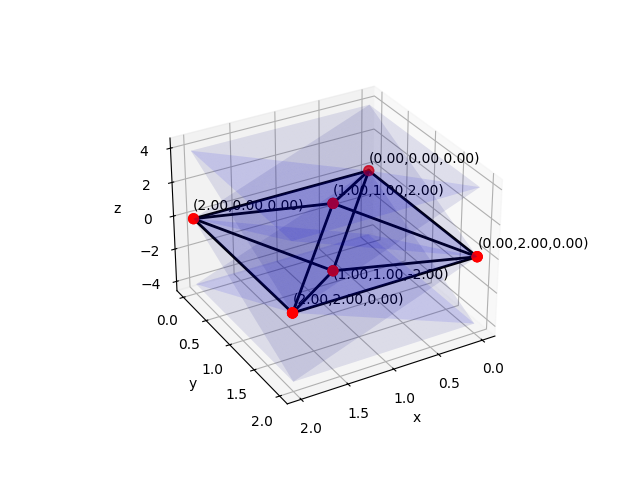

In [7]:
cons2 = [
    [0, -2, 1, 0],
    [-2, 0, 1, 0],
    [-2, 0, -1, 0],
    [0, -2, -1, 0],
    [2, 0, -1, -4],
    [2, 0, 1, -4],
    [0, 2, 1, -4],
    [0, 2, -1, -4]]

verts2 = [
    [1, 1,  -2],
    [0,  2,  0],
    [0, 0, 0],
    [1, 1, 2],
    [2, 0, 0],
    [2, 2, 0]]

xyz_bnds = [[0,2],[0, 2],[-2, 2]]
p2 = ThreeDPolyhedronData(cons2, verts2, xyz_bnds)
p2.plot_polyhedron()

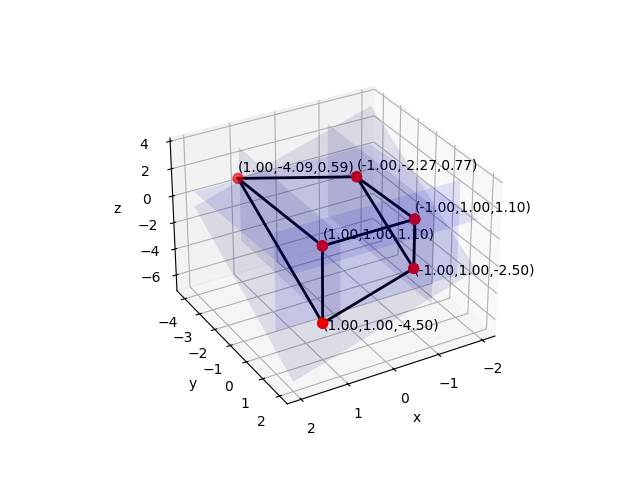

In [8]:

cons3 = [
    [1, 0, 0, -1],
    [-1, 0, 0, -1],
    [0, 1, 0, -1],
    [0, -1, 10, -10],
    [-10, -10, -10, -25]
]

verts3= [
    [-1, 1, 11/10],
    [1, 1, 11/10],
    [1, 1, -4.5],
    [1, -90/22,13/22],
    [-1, -50/22, 17/22],
    [-1, 1, -2.5]
]

xyz_bnds = [[-2,2],[-4, 2],[-4, 3]]
p3 = ThreeDPolyhedronData(cons3, verts3, xyz_bnds)
p3.plot_polyhedron()

## That's All Folks